<a href="https://colab.research.google.com/github/anovick1/Baseline/blob/main/BraTS_Men.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and imports

In [1]:
!pip -q install monai nibabel torchmetrics

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob, time, json, random, numpy as np, torch, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from monai.data import Dataset, list_data_collate, decollate_batch
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Spacingd,
    NormalizeIntensityd, RandFlipd, RandRotate90d, ConcatItemsd, ToTensord,
    RandCropByPosNegLabeld, MapTransform, AsDiscrete,
    KeepLargestConnectedComponent, FillHoles
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

import monai
monai.utils.set_determinism(42)
torch.backends.cudnn.benchmark = True

# SAVE_DIR = Path("/content/drive/MyDrive/BraTS_MEN_baseline_v2")
# SAVE_DIR.mkdir(parents=True, exist_ok=True)
# print("Saving to:", SAVE_DIR)
# NOTE: derive SAVE_DIR later after we pick the loss/run name.
RUN_NAME = None          # will be set in a later cell (loss block)
SAVE_DIR = None          # placeholder; we’ll override after we set RUN_NAME


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 69.4 MB/s eta 0:00:00
Mounted at /content/drive
Device: cuda


Path and Index the dataset (4 inputs and 1 mask per subject)

In [2]:
# # Copy once per session (fast local I/O)
!rsync -a --info=progress2 "/content/drive/MyDrive/BraTS2023_MEN_Data/BraTS-MEN-Train/" "/content/BraTS-MEN-Train/"

LOCAL_TRAIN_ROOT = "/content/BraTS-MEN-Train"
DRIVE_TRAIN_ROOT = "/content/drive/MyDrive/BraTS2023_MEN_Data/BraTS-MEN-Train"
TRAIN_ROOT = LOCAL_TRAIN_ROOT if os.path.isdir(LOCAL_TRAIN_ROOT) else DRIVE_TRAIN_ROOT
print("Using TRAIN_ROOT:", TRAIN_ROOT)

# # Robust file patterns
# F_PATTERNS = {
#     "t1n": ["*t1n.nii.gz", "*t1.nii.gz"],
#     "t2w": ["*t2w.nii.gz", "*t2.nii.gz"],
#     "t2f": ["*t2f.nii.gz", "*flair.nii.gz", "*t2flair.nii.gz", "*flair*nii.gz"],
#     "t1c": ["*t1c.nii.gz", "*t1ce.nii.gz", "*t1ce*nii.gz"],
#     "seg": ["*seg.nii.gz", "*mask.nii.gz", "*segmentation.nii.gz"],
# }

# def find_one(patterns, folder):
#     for pat in patterns:
#         hits = list(Path(folder).glob(pat))
#         if hits: return str(hits[0])
#     return None

# def collect_subject_dicts(train_root):
#     subs = sorted([p for p in Path(train_root).glob("BraTS-MEN-*") if p.is_dir()])
#     items, miss = [], 0
#     for sd in subs:
#         d = {k: find_one(v, sd) for k, v in F_PATTERNS.items()}
#         if all(d.values()): items.append(d)
#         else: miss += 1
#     print(f"Total subject dirs: {len(subs)} | usable: {len(items)} | missing: {miss}")
#     return items

# split_path = SAVE_DIR / "subject_split.json"

# if split_path.exists():
#     print("Loading existing split:", split_path)
#     payload = json.loads(Path(split_path).read_text())
#     train_items, val_items = payload["train"], payload["val"]
# else:
#     print("Creating new split…")
#     all_items = collect_subject_dicts(TRAIN_ROOT)
#     random.seed(42); random.shuffle(all_items)
#     split = int(0.8 * len(all_items))
#     train_items, val_items = all_items[:split], all_items[split:]
#     # ensure at least one FG in val
#     import nibabel as nib
#     def has_fg(it):
#         try: return (nib.load(it["seg"]).get_fdata() > 0).any()
#         except: return False
#     if not any(has_fg(v) for v in val_items[:min(20,len(val_items))]):
#         for j,it in enumerate(train_items[:200]):
#             if has_fg(it):
#                 val_items = [it] + val_items
#                 train_items = train_items[:j]+train_items[j+1:]
#                 print("[Adjust] moved FG case to val"); break
#     payload = {"train_root": TRAIN_ROOT, "train": train_items, "val": val_items}
#     Path(split_path).write_text(json.dumps(payload, indent=2))
#     print("Saved split to:", split_path)

# print(f"Train subjects: {len(train_items)} | Val subjects: {len(val_items)}")

# Reuse the frozen split from your v2 run
from pathlib import Path
import json, os, nibabel as nib

SPLIT_JSON = Path("/content/drive/MyDrive/BraTS_MEN_baseline_v2/subject_split.json")

with open(SPLIT_JSON, "r") as f:
    payload = json.load(f)

TRAIN_ROOT  = payload["train_root"]            # "/content/BraTS-MEN-Train"
train_items = payload["train"]
val_items   = payload["val"]

print("Loaded split:", SPLIT_JSON)
print(f"Train subjects: {len(train_items)} | Val subjects: {len(val_items)}")



 20,695,540,133 100%    4.24MB/s    1:17:37 (xfr#5000, to-chk=0/6001)
Using TRAIN_ROOT: /content/BraTS-MEN-Train
Loaded split: /content/drive/MyDrive/BraTS_MEN_baseline_v2/subject_split.json
Train subjects: 800 | Val subjects: 200


Transforms (spacing, binarize, crops/aug)

In [3]:
# === V2-like transforms (clean baseline) ===
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Spacingd,
    NormalizeIntensityd, RandFlipd, RandRotate90d, ConcatItemsd, ToTensord,
    RandCropByPosNegLabeld, OneOf, MapTransform
)

# Add BinarizeSeg class
class BinarizeSeg(MapTransform):
    def __init__(self, keys=("seg",), allow_missing_keys=False):
        super().__init__(keys, allow_missing_keys)
    def __call__(self, data):
        import torch as _T, numpy as _N
        d = dict(data)
        for k in self.keys:
            y = d[k]
            if isinstance(y, _T.Tensor): d[k] = (y > 0).float()
            else: d[k] = (_N.asarray(y) > 0).astype(_N.float32)
        return d

keys_img = ["t1n","t2w","t2f","t1c"]
key_seg  = "seg"
ROI_128  = (128,128,128)

_common = [
    LoadImaged(keys=keys_img+[key_seg], image_only=True),
    EnsureTyped(keys=keys_img+[key_seg]),
    EnsureChannelFirstd(keys=keys_img+[key_seg]),
    Spacingd(keys=keys_img, pixdim=(1,1,1), mode="bilinear"),
    Spacingd(keys=[key_seg],  pixdim=(1,1,1), mode="nearest"),
    BinarizeSeg(keys=(key_seg,)),  # CRITICAL: Ensure binary masks
    NormalizeIntensityd(keys=keys_img, nonzero=True, channel_wise=True),
]

train_transforms = Compose(_common + [
    OneOf([
        RandCropByPosNegLabeld(
            keys=keys_img+[key_seg], label_key=key_seg,
            spatial_size=(128,128,128), pos=2, neg=1, num_samples=2
        ),
        RandCropByPosNegLabeld(
            keys=keys_img+[key_seg], label_key=key_seg,
            spatial_size=(96,96,96), pos=2, neg=1, num_samples=2
        ),
    ], weights=[0.7, 0.3]),
    RandFlipd(keys=keys_img+[key_seg], spatial_axis=[0,1,2], prob=0.5),
    RandRotate90d(keys=keys_img+[key_seg], prob=0.2, max_k=3),
    ConcatItemsd(keys=keys_img, name="image", dim=0),
    ToTensord(keys=["image", key_seg]),
])

val_transforms = Compose(_common + [
    ConcatItemsd(keys=keys_img, name="image", dim=0),
    ToTensord(keys=["image", key_seg]),
])


Dataset and Loaders

In [11]:
from monai.data import Dataset, list_data_collate
from torch.utils.data import DataLoader

train_ds = Dataset(train_items, transform=train_transforms)
val_ds   = Dataset(val_items,   transform=val_transforms)

# Clean any old loaders if you re-run
import gc
try: del train_loader, val_loader
except NameError: pass
gc.collect()

train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True,
    num_workers=4, pin_memory=True, persistent_workers=True,
    collate_fn=list_data_collate
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False,
    num_workers=4, pin_memory=True, persistent_workers=True,
    collate_fn=list_data_collate
)

print("len(train_ds) =", len(train_ds), "| len(val_ds) =", len(val_ds))

len(train_ds) = 800 | len(val_ds) = 200


Model, Loss, Optimizer, Metrics - DiceCE

In [12]:
# @title
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete, Compose, FillHoles

model = UNet(
    spatial_dims=3, in_channels=4, out_channels=1,
    channels=(32,64,128,256,512), strides=(2,2,2,2), num_res_units=2
).to(device)

criterion = DiceCELoss(sigmoid=True, squared_pred=True, to_onehot_y=False)
loss_fn   = criterion
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5)

dice_metric = DiceMetric(include_background=False, reduction="mean")

def soft_dice_on_probs(probs: torch.Tensor, target: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    probs, target: (B,1,H,W,D) in [0,1]
    returns per-batch dice tensor (B,)
    """
    p = probs
    y = target
    num = 2.0 * (p * y).sum(dim=(1,2,3,4))
    den = (p + y).sum(dim=(1,2,3,4)).clamp_min(eps)
    return num / den

def bin_metrics_from_masks(pred: torch.Tensor, gt: torch.Tensor, eps: float = 1e-6):
    """
    pred, gt: (B,1,H,W,D) tensors with values in {0,1} or floats -> will be binarized.
    Returns IoU, Precision, Recall as python floats (averaged over batch).
    """
    p = (pred.detach().float() > 0.5).cpu().numpy().astype(np.uint8)
    g = (gt.detach().float()   > 0.5).cpu().numpy().astype(np.uint8)

    tp = int((p & g).sum())
    fp = int((p & (1 - g)).sum())
    fn = int(((1 - p) & g).sum())

    iou  = tp / (tp + fp + fn + eps)
    prec = tp / (tp + fp + eps)
    rec  = tp / (tp + fn + eps)
    return iou, prec, rec

# AMP
scaler  = torch.amp.GradScaler('cuda', enabled=(device.type=='cuda'))
ampctx  = lambda: torch.amp.autocast('cuda', enabled=(device.type=='cuda'))

# Monitoring post-proc (only for in-training val prints)
post_proc = Compose([
    AsDiscrete(threshold=0.60),
    KeepLargestConnectedComponent(applied_labels=[1]),
    FillHoles(applied_labels=[1]),
])

RUN_NAME = "BraTS_MEN_v3_dicece_smalltumor_push"



Focal DiceCE

In [ ]:
# @title
from monai.networks.nets import UNet
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete, Compose, FillHoles
from monai.losses import DiceCELoss, FocalLoss
import torch, torch.nn as nn

model = UNet(
    spatial_dims=3, in_channels=4, out_channels=1,
    channels=(32,64,128,256,512), strides=(2,2,2,2), num_res_units=2
).to(device)

# Simple weighted combination of MONAI losses
class WeightedFocalDiceCE(nn.Module):
    def __init__(self, focal_weight=0.4, dice_weight=0.6, gamma=1.5):
        super().__init__()
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight

        # MONAI's battle-tested implementations
        self.dice_ce = DiceCELoss(
            include_background=False, to_onehot_y=False, sigmoid=True, squared_pred=True
        )
        self.focal = FocalLoss(
            include_background=False, to_onehot_y=False, gamma=gamma, weight=None
        )

    def forward(self, logits, target):
        dice_ce_loss = self.dice_ce(logits, target)
        focal_loss = self.focal(logits, target)

        return self.dice_weight * dice_ce_loss + self.focal_weight * focal_loss

# Two instances for clean logging
criterion_train = WeightedFocalDiceCE(focal_weight=0.4, dice_weight=0.6, gamma=1.5).to(device)
criterion_log = WeightedFocalDiceCE(focal_weight=0.4, dice_weight=0.6, gamma=1.5)  # CPU

loss_fn = criterion_train  # Keep for compatibility
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5)

dice_metric = DiceMetric(include_background=False, reduction="mean")

def soft_dice_on_probs(probs: torch.Tensor, target: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    probs, target: (B,1,H,W,D) in [0,1]
    returns per-batch dice tensor (B,)
    """
    p = probs
    y = target
    num = 2.0 * (p * y).sum(dim=(1,2,3,4))
    den = (p + y).sum(dim=(1,2,3,4)).clamp_min(eps)
    return num / den

def bin_metrics_from_masks(pred: torch.Tensor, gt: torch.Tensor, eps: float = 1e-6):
    """
    pred, gt: (B,1,H,W,D) tensors with values in {0,1} or floats -> will be binarized.
    Returns IoU, Precision, Recall as python floats (averaged over batch).
    """
    p = (pred.detach().float() > 0.5).cpu().numpy().astype(np.uint8)
    g = (gt.detach().float()   > 0.5).cpu().numpy().astype(np.uint8)

    tp = int((p & g).sum())
    fp = int((p & (1 - g)).sum())
    fn = int(((1 - p) & g).sum())

    iou  = tp / (tp + fp + fn + eps)
    prec = tp / (tp + fp + eps)
    rec  = tp / (tp + fn + eps)
    return iou, prec, rec

# AMP
scaler  = torch.amp.GradScaler('cuda', enabled=(device.type=='cuda'))
ampctx  = lambda: torch.amp.autocast('cuda', enabled=(device.type=='cuda'))

# Monitoring post-proc (only for in-training val prints)
post_proc = Compose([
    AsDiscrete(threshold=0.60),
    KeepLargestConnectedComponent(applied_labels=[1]),
    FillHoles(applied_labels=[1]),
])

RUN_NAME = "BraTS_MEN_v3_monai_focal_dicece"

Tversky + Focal

In [13]:
# @title
from monai.networks.nets import UNet
from monai.losses import TverskyLoss, FocalLoss
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete, Compose, KeepLargestConnectedComponent, FillHoles
import torch, torch.nn as nn

model = UNet(
    spatial_dims=3, in_channels=4, out_channels=1,
    channels=(32,64,128,256,512), strides=(2,2,2,2), num_res_units=2
).to(device)

# Tversky + Focal for aggressive small tumor detection
class TverskyFocalLoss(nn.Module):
    def __init__(self, tversky_weight=0.7, focal_weight=0.3,
                  alpha=0.3, beta=0.7, gamma=2.0):
        super().__init__()
        self.tversky_weight = tversky_weight
        self.focal_weight = focal_weight

        # Tversky: alpha=0.3 means FN penalty is 70% (catches more small tumors)
        self.tversky = TverskyLoss(
            include_background=False, to_onehot_y=False, sigmoid=True,
            alpha=alpha, beta=beta, smooth_nr=1e-5, smooth_dr=1e-5
        )

        # Focal: gamma=2.0 for strong hard example focus
        self.focal = FocalLoss(
            include_background=False, to_onehot_y=False,
            gamma=gamma, weight=None
        )

    def forward(self, logits, target):
        tversky_loss = self.tversky(logits, target)
        focal_loss = self.focal(logits, target)

        total = self.tversky_weight * tversky_loss + self.focal_weight * focal_loss

        # Debug if needed
        if total < 0:
            print(f"[WARNING] Negative loss: Tversky={tversky_loss:.4f}, Focal={focal_loss:.4f}, Total={total:.4f}")

        return total

# Create the loss
loss_fn = TverskyFocalLoss(
    tversky_weight=0.7, focal_weight=0.3,
    alpha=0.3, beta=0.7, gamma=2.0
)

optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5)

# Use MONAI's DiceMetric for validation
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Helper functions for metrics
def soft_dice_on_probs(probs: torch.Tensor, target: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    probs, target: (B,1,H,W,D) in [0,1]
    returns per-batch dice tensor (B,)
    """
    p = probs.clamp(0, 1)
    y = target.clamp(0, 1)

    # Sum over spatial dimensions only (not batch or channel)
    num = 2.0 * (p * y).sum(dim=(2,3,4))  # Shape: (B,1)
    den = (p + y).sum(dim=(2,3,4)) + eps  # Shape: (B,1)

    # Return dice scores with shape (B,)
    return (num / den).squeeze(1)

def bin_metrics_from_masks(pred: torch.Tensor, gt: torch.Tensor, eps: float = 1e-6):
    """
    pred, gt: (B,1,H,W,D) tensors with values in {0,1} or floats -> will be binarized.
    Returns IoU, Precision, Recall as python floats (averaged over batch).
    """
    p = (pred.detach().float() > 0.5).cpu().numpy().astype(np.uint8)
    g = (gt.detach().float()   > 0.5).cpu().numpy().astype(np.uint8)

    tp = int((p & g).sum())
    fp = int((p & (1 - g)).sum())
    fn = int(((1 - p) & g).sum())

    iou  = tp / (tp + fp + fn + eps)
    prec = tp / (tp + fp + eps)
    rec  = tp / (tp + fn + eps)
    return iou, prec, rec

# AMP setup
scaler = torch.amp.GradScaler('cuda', enabled=(device.type=='cuda'))
ampctx = lambda: torch.amp.autocast('cuda', enabled=(device.type=='cuda'))

# Post-processing
post_proc = Compose([
    AsDiscrete(threshold=0.60),
    KeepLargestConnectedComponent(applied_labels=[1]),
    FillHoles(applied_labels=[1]),
])

RUN_NAME = "BraTS_MEN_v3.1_tversky_focal"

Set Save Directory

In [6]:
# Derive SAVE_DIR from RUN_NAME and persist config
from pathlib import Path, PurePosixPath
import json, time

assert RUN_NAME is not None, "Set RUN_NAME above."
SAVE_DIR = Path("/content/drive/MyDrive") / RUN_NAME
SAVE_DIR.mkdir(parents=True, exist_ok=True)
print("Saving to:", SAVE_DIR)

CONFIG_JSON = SAVE_DIR / "config.json"
cfg = {
    "run_name": RUN_NAME,
    "split_json": str(PurePosixPath("/content/drive/MyDrive/BraTS_MEN_baseline_v2/subject_split.json")),
    "loss": "DiceCE",
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
}
CONFIG_JSON.write_text(json.dumps(cfg, indent=2))
print("Saved:", CONFIG_JSON)


Saving to: /content/drive/MyDrive/BraTS_MEN_v3_dicece_smalltumor_push
Saved: /content/drive/MyDrive/BraTS_MEN_v3_dicece_smalltumor_push/config.json


Training and Validation, save model and chart to drive

=== V3 Training: Tversky + Focal ===


/usr/local/lib/python3.12/dist-packages/monai/losses/tversky.py:136: UserWarning: single channel prediction, `include_background=False` ignored.
  warnings.warn("single channel prediction, `include_background=False` ignored.")
/usr/local/lib/python3.12/dist-packages/monai/losses/focal_loss.py:147: UserWarning: single channel prediction, `include_background=False` ignored.
  warnings.warn("single channel prediction, `include_background=False` ignored.")


[E1] Batch 0/800 | Loss: 0.8309 | Dice: 0.0022
[E1] Batch 50/800 | Loss: 0.7888 | Dice: 0.0020
[E1] Batch 100/800 | Loss: 0.7414 | Dice: 0.0344
[E1] Batch 150/800 | Loss: 0.7769 | Dice: 0.0014
[E1] Batch 200/800 | Loss: 0.7893 | Dice: 0.0049
[E1] Batch 250/800 | Loss: 0.7464 | Dice: 0.0236
[E1] Batch 300/800 | Loss: 0.5370 | Dice: 0.2543
[E1] Batch 350/800 | Loss: 0.7689 | Dice: 0.0030
[E1] Batch 400/800 | Loss: 0.7065 | Dice: 0.0534
[E1] Batch 450/800 | Loss: 0.7585 | Dice: 0.0119
[E1] Batch 500/800 | Loss: 0.7650 | Dice: 0.0037
[E1] Batch 550/800 | Loss: 0.7483 | Dice: 0.0175
[E1] Batch 600/800 | Loss: 0.6893 | Dice: 0.0708
[E1] Batch 650/800 | Loss: 0.7652 | Dice: 0.0014
[E1] Batch 700/800 | Loss: 0.7647 | Dice: 0.0006
[E1] Batch 750/800 | Loss: 0.6374 | Dice: 0.1173


/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  out

Epoch 01 | 622.4s | LR: 1.00e-04
  Train → Loss: 0.7141 | SoftDice: 0.0560 | IoU: 0.0230
  Val   → Loss: 0.7459 | SoftDice: 0.0152 | Dice: 0.3297
           IoU: 0.2516 | Prec: 0.2540 | Rec: 0.6766 | F1: 0.3694
  ✓ NEW BEST: Dice(0.3297) | IoU(0.2516) | Recall(0.6766) | SoftDice(0.0152)
[E2] Batch 0/800 | Loss: 0.7149 | Dice: 0.0463
[E2] Batch 50/800 | Loss: 0.7637 | Dice: 0.0008
[E2] Batch 100/800 | Loss: 0.7107 | Dice: 0.0447
[E2] Batch 150/800 | Loss: 0.7337 | Dice: 0.0377
[E2] Batch 200/800 | Loss: 0.4117 | Dice: 0.3578
[E2] Batch 250/800 | Loss: 0.7608 | Dice: 0.0008
[E2] Batch 300/800 | Loss: 0.6792 | Dice: 0.0699
[E2] Batch 350/800 | Loss: 0.5590 | Dice: 0.1854
[E2] Batch 400/800 | Loss: 0.7431 | Dice: 0.0374
[E2] Batch 450/800 | Loss: 0.7601 | Dice: 0.0039
[E2] Batch 500/800 | Loss: 0.7494 | Dice: 0.0083
[E2] Batch 550/800 | Loss: 0.7603 | Dice: 0.0000
[E2] Batch 600/800 | Loss: 0.7066 | Dice: 0.0442
[E2] Batch 650/800 | Loss: 0.6548 | Dice: 0.0870
[E2] Batch 700/800 | Loss: 0.

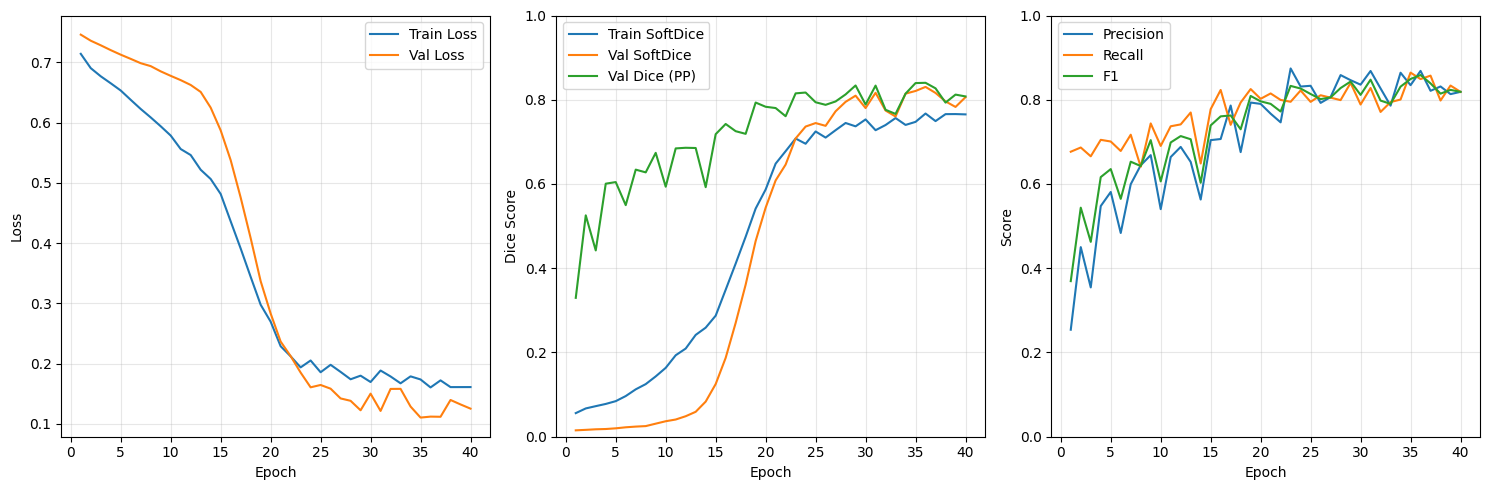

History saved: /content/drive/MyDrive/BraTS_MEN_v3.1_tversky_focal/training_history_v3_clean.csv
Plots saved: /content/drive/MyDrive/BraTS_MEN_v3.1_tversky_focal/learning_curves_v3.png


In [ ]:
# @title
# ===== Clean Training Loop (detached FP32 logging, no bogus skips) =====
from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt, time, torch, pandas as pd
from pathlib import Path

EPOCHS = 40
PATIENCE = 10

CKPTS = {
    "dice":    SAVE_DIR / "unet3d_v3_best_dice.pt",
    "iou":     SAVE_DIR / "unet3d_v3_best_iou.pt",
    "recall":  SAVE_DIR / "unet3d_v3_best_recall.pt",
    "softdice":SAVE_DIR / "unet3d_v3_best_softdice.pt",
}

history = {
    "epoch": [], "train_loss": [], "train_softdice": [], "train_iou": [],
    "val_loss": [], "val_softdice": [], "val_dice": [], "val_iou": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "lr": []
}

best = {"dice": -1.0, "iou": -1.0, "recall": -1.0, "softdice": -1.0}
wait = 0
ROI = (128, 128, 128)

print("=== V3 Training: Tversky + Focal ===")

for epoch in range(1, EPOCHS + 1):
    if device.type == "cuda":
        torch.cuda.synchronize()
    t0 = time.time()

    # ===== TRAIN =====
    model.train()
    train_loss_sum = train_softdice_sum = train_iou_sum = 0.0
    n_train = 0

    for i, batch in enumerate(train_loader):
        imgs = batch["image"].to(device)
        segs = batch["seg"].to(device).float()

        optimizer.zero_grad(set_to_none=True)

        # ---- Forward pass and loss under AMP ----
        with ampctx():
            logits = model(imgs)
            loss = loss_fn(logits, segs)

        # ---- Check for NaN/inf ----
        if not torch.isfinite(loss):
            print(f"[Skip] non-finite loss at epoch {epoch} batch {i}")
            continue

        # ---- Backward pass ----
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        # ---- Calculate metrics on detached tensors ----
        with torch.no_grad():
            # Get loss value after optimization step
            loss_val = loss.item()

            # Calculate metrics
            probs = torch.sigmoid(logits).clamp(1e-6, 1-1e-6)
            train_softdice = soft_dice_on_probs(probs, segs).mean().item()
            preds_bin = (probs > 0.5).float()
            train_iou, _, _ = bin_metrics_from_masks(preds_bin, segs)

        train_loss_sum += loss_val
        train_softdice_sum += train_softdice
        train_iou_sum += train_iou
        n_train += 1

        if i % 50 == 0:
            print(f"[E{epoch}] Batch {i}/{len(train_loader)} | Loss: {loss_val:.4f} | Dice: {train_softdice:.4f}")

    # ===== VALIDATION =====
    model.eval()
    val_loss_sum = val_softdice_sum = val_dice_sum = 0.0
    val_iou_sum = val_prec_sum = val_rec_sum = 0.0
    n_val = 0

    with torch.no_grad():
        for batch in val_loader:
            imgs = batch["image"].to(device)
            segs = batch["seg"].to(device).float()

            with ampctx():
                logits = sliding_window_inference(
                    imgs, ROI, sw_batch_size=2, predictor=model, overlap=0.25
                )
                loss_v = loss_fn(logits, segs).item()

            val_loss_sum += loss_v

            probs = torch.sigmoid(logits).clamp(1e-6, 1-1e-6)
            val_softdice = soft_dice_on_probs(probs, segs).mean().item()

            # post-processed metrics
            preds_pp = post_proc(probs)
            val_dice = soft_dice_on_probs(preds_pp, segs).mean().item()
            val_iou, val_prec, val_rec = bin_metrics_from_masks(preds_pp, segs)

            val_softdice_sum += val_softdice
            val_dice_sum += val_dice
            val_iou_sum += val_iou
            val_prec_sum += val_prec
            val_rec_sum += val_rec
            n_val += 1

    # Averages
    train_loss    = train_loss_sum    / max(1, n_train)
    train_soft    = train_softdice_sum/ max(1, n_train)
    train_iou     = train_iou_sum     / max(1, n_train)

    val_loss      = val_loss_sum      / max(1, n_val)
    val_soft      = val_softdice_sum  / max(1, n_val)
    val_dice      = val_dice_sum      / max(1, n_val)
    val_iou_m     = val_iou_sum       / max(1, n_val)
    val_prec      = val_prec_sum      / max(1, n_val)
    val_rec       = val_rec_sum       / max(1, n_val)
    val_f1        = 2 * val_prec * val_rec / (val_prec + val_rec + 1e-8)

    current_lr = optimizer.param_groups[0]["lr"]
    scheduler.step(val_dice)  # step on actual dice, not soft dice

    # Record
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["train_softdice"].append(train_soft)
    history["train_iou"].append(train_iou)
    history["val_loss"].append(val_loss)
    history["val_softdice"].append(val_soft)
    history["val_dice"].append(val_dice)
    history["val_iou"].append(val_iou_m)
    history["val_precision"].append(val_prec)
    history["val_recall"].append(val_rec)
    history["val_f1"].append(val_f1)
    history["lr"].append(current_lr)

    if device.type == "cuda":
        torch.cuda.synchronize()
    dt = time.time() - t0

    print(f"Epoch {epoch:02d} | {dt:.1f}s | LR: {current_lr:.2e}")
    print(f"  Train → Loss: {train_loss:6.4f} | SoftDice: {train_soft:.4f} | IoU: {train_iou:.4f}")
    print(f"  Val   → Loss: {val_loss:6.4f} | SoftDice: {val_soft:.4f} | Dice: {val_dice:.4f}")
    print(f"           IoU: {val_iou_m:.4f} | Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")

    # Checkpoints
    improved = []
    if val_dice > best["dice"]:
        best["dice"] = val_dice
        torch.save(model.state_dict(), CKPTS["dice"])
        improved.append(f"Dice({val_dice:.4f})")
    if val_iou_m > best["iou"]:
        best["iou"] = val_iou_m
        torch.save(model.state_dict(), CKPTS["iou"])
        improved.append(f"IoU({val_iou_m:.4f})")
    if val_rec > best["recall"]:
        best["recall"] = val_rec
        torch.save(model.state_dict(), CKPTS["recall"])
        improved.append(f"Recall({val_rec:.4f})")
    if val_soft > best["softdice"]:
        best["softdice"] = val_soft
        torch.save(model.state_dict(), CKPTS["softdice"])
        improved.append(f"SoftDice({val_soft:.4f})")

    if improved:
        print(f"  ✓ NEW BEST: {' | '.join(improved)}")
        wait = 0
    else:
        wait += 1

    # Early stopping
    if epoch >= 15 and val_dice < 0.25:
        print("[Stop] Dice still <0.25 after 15 epochs")
        break
    if wait >= PATIENCE:
        print(f"[Stop] No improvement for {PATIENCE} epochs")
        break

print("\n=== TRAINING COMPLETE ===")
for metric, value in best.items():
    print(f"Best {metric:10s}: {value:.4f}")

# Save history and plots
df_history = pd.DataFrame(history)
df_history.to_csv(SAVE_DIR / "training_history_v3_clean.csv", index=False)

# Plot learning curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history["epoch"], history["train_softdice"], label="Train SoftDice")
plt.plot(history["epoch"], history["val_softdice"], label="Val SoftDice")
plt.plot(history["epoch"], history["val_dice"], label="Val Dice (PP)")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.subplot(1, 3, 3)
plt.plot(history["epoch"], history["val_precision"], label="Precision")
plt.plot(history["epoch"], history["val_recall"], label="Recall")
plt.plot(history["epoch"], history["val_f1"], label="F1")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig(SAVE_DIR / "learning_curves_v3.png", dpi=150)
plt.show()

print(f"History saved: {SAVE_DIR / 'training_history_v3_clean.csv'}")
print(f"Plots saved: {SAVE_DIR / 'learning_curves_v3.png'}")



V2 Small Lesion Finetune Traing Loop




SAVE_DIR: /content/drive/MyDrive/BraTS_MEN_v2_6b_tversky
Train small: 289 / 800 | Val small: 83 / 200
Loaded V2.5 weights from: /content/drive/MyDrive/BraTS_MEN_v2_5_small_tune/unet3d_v2_5_small_best.pt


/tmp/ipython-input-3425789478.py:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-3425789478.py:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-3425789478.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], wh

[Epoch 01] lr=3.33e-05  train_loss=0.5676  val_small_dice=0.7201
  ↳ Saved new best (EMA, small-lesion Dice): 0.7201
[Epoch 02] lr=6.67e-05  train_loss=0.4494  val_small_dice=0.7188
[Epoch 03] lr=1.00e-04  train_loss=0.3813  val_small_dice=0.7305
  ↳ Saved new best (EMA, small-lesion Dice): 0.7305
[Epoch 04] lr=9.92e-05  train_loss=0.3612  val_small_dice=0.7117
[Epoch 05] lr=9.68e-05  train_loss=0.3552  val_small_dice=0.7139
[Epoch 06] lr=9.29e-05  train_loss=0.3013  val_small_dice=0.7462
  ↳ Saved new best (EMA, small-lesion Dice): 0.7462
[Epoch 07] lr=8.76e-05  train_loss=0.3115  val_small_dice=0.7493
  ↳ Saved new best (EMA, small-lesion Dice): 0.7493
[Epoch 08] lr=8.11e-05  train_loss=0.3060  val_small_dice=0.7478
[Epoch 09] lr=7.37e-05  train_loss=0.3034  val_small_dice=0.7451
[Epoch 10] lr=6.55e-05  train_loss=0.3243  val_small_dice=0.7459
[Epoch 11] lr=5.69e-05  train_loss=0.2995  val_small_dice=0.7307
[Epoch 12] lr=4.81e-05  train_loss=0.2876  val_small_dice=0.7529
  ↳ Saved ne

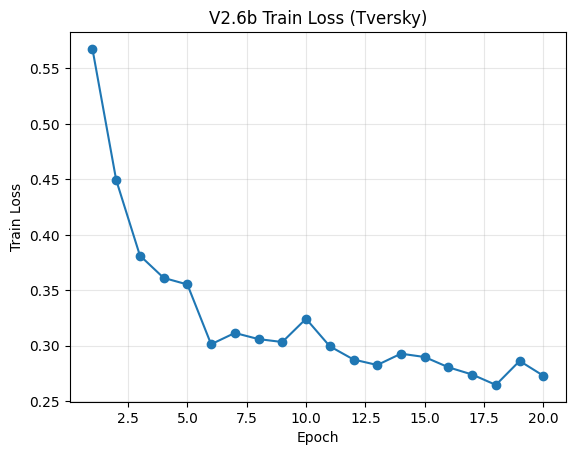

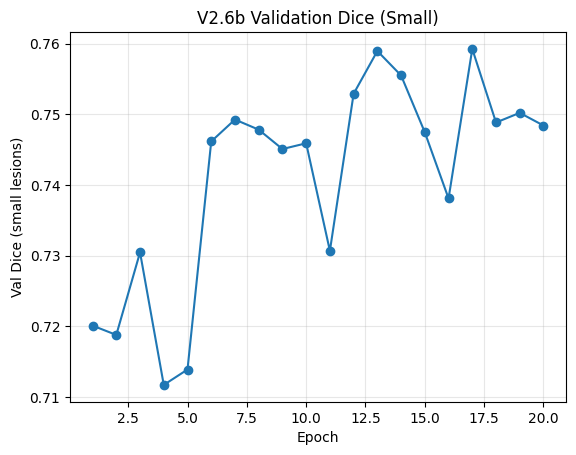

Best small-lesion val Dice: 0.7593
Checkpoint: /content/drive/MyDrive/BraTS_MEN_v2_6b_tversky/unet3d_v2_6b_best.pt


In [17]:
# ===== V2.6b small-lesion fine-tune (Tversky) with EMA, dropout, freeze, warmup+cosine =====
import os, json, math, random
from pathlib import Path
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from monai.data import Dataset, list_data_collate
from monai.networks.nets import UNet
from monai.losses import TverskyLoss
from monai.metrics import DiceMetric
from monai.transforms import Compose, AsDiscrete
from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt
import pandas as pd

# ----------------- config -----------------
V25_CKPT = Path("/content/drive/MyDrive/BraTS_MEN_v2_5_small_tune/unet3d_v2_5_small_best.pt")

SMALL_CUTOFF_CC   = 5.0
BLEND_WITH_ALL    = True
BLEND_RATIO_SMALL = 0.95   # heavier small weighting
EPOCHS            = 20
WARMUP_EPOCHS     = 3
LR_BASE           = 1e-4
MIN_LR            = 5e-6
WEIGHT_DECAY      = 1e-5
BATCH_SIZE        = 1
SW_BATCH          = 2
SW_OVERLAP        = 0.25
DROPOUT_P         = 0.10
FREEZE_EPOCHS     = 2       # freeze encoder for first N epochs

ROI    = ROI if "ROI" in globals() else (128,128,128)
DEVICE = device if "device" in globals() else torch.device("cuda" if torch.cuda.is_available() else "cpu")

RUN_NAME = "BraTS_MEN_v2_6b_tversky"
SAVE_DIR = Path("/content/drive/MyDrive") / RUN_NAME
SAVE_DIR.mkdir(parents=True, exist_ok=True)
print("SAVE_DIR:", SAVE_DIR)

to_binary = Compose([AsDiscrete(threshold=0.5)])

# ----------------- sanity: use existing items & transforms -----------------
assert "train_items" in globals() and "val_items" in globals(), "Need train_items / val_items defined."
assert "train_transforms" in globals() and "val_transforms" in globals(), "Need train_transforms / val_transforms defined."

# ----------------- helpers -----------------
def set_seed(seed=1337):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed()

def case_volume_cc(seg_path: str) -> float:
    img = nib.load(seg_path)
    sp = np.asarray(img.header.get_zooms()[:3], dtype=np.float32)
    arr = img.get_fdata()
    return float((arr > 0).sum() * np.prod(sp) / 1000.0)

def split_small_large(items, seg_key="seg"):
    small, large = [], []
    for i, it in enumerate(items):
        seg_path = it[seg_key] if isinstance(it[seg_key], str) else str(it[seg_key])
        (small if case_volume_cc(seg_path) < SMALL_CUTOFF_CC else large).append(i)
    return small, large

# ----------------- datasets & loaders -----------------
train_ds_full = Dataset(train_items, transform=train_transforms)
val_ds_full   = Dataset(val_items,   transform=val_transforms)

tr_small_idx, tr_large_idx = split_small_large(train_items)
va_small_idx, _            = split_small_large(val_items)
print(f"Train small: {len(tr_small_idx)} / {len(train_items)} | Val small: {len(va_small_idx)} / {len(val_items)}")

if BLEND_WITH_ALL and len(tr_large_idx) > 0:
    weights = np.zeros(len(train_items), dtype=np.float32)
    weights[tr_small_idx] = BLEND_RATIO_SMALL
    not_small = [i for i in range(len(train_items)) if i not in tr_small_idx]
    weights[not_small] = (1.0 - BLEND_RATIO_SMALL)
    sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_items), replacement=True)
    train_loader = DataLoader(
        train_ds_full, batch_size=BATCH_SIZE, sampler=sampler,
        num_workers=4, pin_memory=True, persistent_workers=True,
        collate_fn=list_data_collate, drop_last=True
    )
else:
    train_ds_small = Subset(train_ds_full, tr_small_idx)
    train_loader = DataLoader(
        train_ds_small, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=4, pin_memory=True, persistent_workers=True,
        collate_fn=list_data_collate, drop_last=True
    )

val_ds_small = Subset(val_ds_full, va_small_idx)
val_loader   = DataLoader(
    val_ds_small, batch_size=1, shuffle=False,
    num_workers=4, pin_memory=True, persistent_workers=True, collate_fn=list_data_collate
)

# ----------------- model / loss / opt -----------------
def build_unet():
    return UNet(
        spatial_dims=3, in_channels=4, out_channels=1,
        channels=(32,64,128,256,512), strides=(2,2,2,2),
        num_res_units=2, dropout=DROPOUT_P
    )

model = build_unet().to(DEVICE)
state = torch.load(V25_CKPT, map_location="cpu")
model.load_state_dict(state, strict=True)
print("Loaded V2.5 weights from:", V25_CKPT)

# EMA twin
ema_model = build_unet().to(DEVICE)
ema_model.load_state_dict(model.state_dict(), strict=True)
for p in ema_model.parameters(): p.requires_grad_(False)

criterion = TverskyLoss(sigmoid=True, alpha=0.65, beta=0.35, smooth_nr=1e-5, smooth_dr=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR_BASE, weight_decay=WEIGHT_DECAY)
dice_metric = DiceMetric(include_background=False, reduction="mean")

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
best_val = -1.0
patience = 7
stall = 0

# Scheduler: warmup + cosine (per epoch)
def lr_at_epoch(ep):
    if ep <= WARMUP_EPOCHS:
        return LR_BASE * ep / max(1, WARMUP_EPOCHS)
    t = (ep - WARMUP_EPOCHS) / max(1, (EPOCHS - WARMUP_EPOCHS))
    return MIN_LR + 0.5 * (LR_BASE - MIN_LR) * (1 + math.cos(math.pi * t))

def set_epoch_lr(ep):
    lr = lr_at_epoch(ep)
    for g in optimizer.param_groups: g["lr"] = lr
    return lr

# Freeze/unfreeze encoder
def set_encoder_requires_grad(net, req: bool):
    for n, p in net.named_parameters():
        if "down" in n:  # MONAI UNet down paths are named 'down*'
            p.requires_grad = req

# EMA update
def ema_update(ema_model, model, mu=0.996):
    with torch.no_grad():
        for p_ema, p in zip(ema_model.parameters(), model.parameters()):
            p_ema.data.mul_(mu).add_(p.data, alpha=1.0 - mu)

def infer_sliding(net, imgs):
    with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        return sliding_window_inference(imgs, ROI, SW_BATCH, net, overlap=SW_OVERLAP)

# ---- history
history = {"epoch": [], "lr": [], "train_loss": [], "val_small_dice": []}

# ----------------- train -----------------
set_encoder_requires_grad(model, False)  # start frozen encoder
for epoch in range(1, EPOCHS + 1):
    # Unfreeze after freeze window
    if epoch == FREEZE_EPOCHS + 1:
        set_encoder_requires_grad(model, True)

    cur_lr = set_epoch_lr(epoch)
    model.train()
    ep_loss, steps = 0.0, 0

    for batch in train_loader:
        imgs = batch["image"].to(DEVICE)
        gts  = batch["seg"].to(DEVICE)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, gts)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        ema_update(ema_model, model, mu=0.996)

        ep_loss += float(loss.item()); steps += 1

    ep_loss /= max(steps, 1)

    # ---- val on small lesions (EMA weights) ----
    ema_model.eval()
    dice_metric.reset()
    with torch.no_grad():
        for vb in val_loader:
            vimg = vb["image"].to(DEVICE)
            vgt  = vb["seg"].to(DEVICE)
            vpred = infer_sliding(ema_model, vimg)
            vpred_bin = to_binary(vpred)
            dice_metric(vpred_bin, (vgt > 0.5).float())
    val_dice = float(dice_metric.aggregate().item())
    dice_metric.reset()

    history["epoch"].append(epoch)
    history["lr"].append(cur_lr)
    history["train_loss"].append(ep_loss)
    history["val_small_dice"].append(val_dice)

    print(f"[Epoch {epoch:02d}] lr={cur_lr:.2e}  train_loss={ep_loss:.4f}  val_small_dice={val_dice:.4f}")

    if val_dice > best_val:
        best_val = val_dice
        torch.save(ema_model.state_dict(), SAVE_DIR / "unet3d_v2_6b_best.pt")
        stall = 0
        print(f"  ↳ Saved new best (EMA, small-lesion Dice): {best_val:.4f}")
    else:
        stall += 1
        if stall >= patience:
            print("Early stopping.")
            break

# ---- save history + curves
hist_path = SAVE_DIR / "training_history_v2_6b.csv"
pd.DataFrame(history).to_csv(hist_path, index=False)
print(f"Saved training history: {hist_path}")

plt.figure()
plt.plot(history["epoch"], history["train_loss"], marker="o")
plt.xlabel("Epoch"); plt.ylabel("Train Loss"); plt.title("V2.6b Train Loss (Tversky)")
plt.grid(True, alpha=0.3)
plt.savefig(SAVE_DIR / "curve_train_loss_v2_6b.png", dpi=150, bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(history["epoch"], history["val_small_dice"], marker="o")
plt.xlabel("Epoch"); plt.ylabel("Val Dice (small lesions)"); plt.title("V2.6b Validation Dice (Small)")
plt.grid(True, alpha=0.3)
plt.savefig(SAVE_DIR / "curve_val_dice_small_v2_6b.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Best small-lesion val Dice: {best_val:.4f}")
print("Checkpoint:", SAVE_DIR / "unet3d_v2_6b_best.pt")


Post Training Analysis



Loaded models: ['V2', 'V2.5', 'V2.6b']  | Ensemble: True | TTA: True


/tmp/ipython-input-959104500.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In py

Processed 20/200


/tmp/ipython-input-959104500.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In py

Processed 40/200


/tmp/ipython-input-959104500.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In py

Processed 60/200


/tmp/ipython-input-959104500.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In py

Processed 80/200


/tmp/ipython-input-959104500.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In py

Processed 100/200


/tmp/ipython-input-959104500.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In py

Processed 120/200


/tmp/ipython-input-959104500.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In py

Processed 140/200


/tmp/ipython-input-959104500.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In py

Processed 160/200


/tmp/ipython-input-959104500.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In py

Processed 180/200


/tmp/ipython-input-959104500.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In py

Processed 200/200
Saved per-case metrics: /content/drive/MyDrive/BraTS_MEN_eval_v26b/v2_v25_v26b_v3_percase.csv

=== Mean metrics (global thr=0.60) ===
                      dice_mean  dice_std  prec_mean  rec_mean  f1_mean  \
model                                                                    
Ens(V2+V2.6b)           0.8554    0.2220     0.9301    0.8144   0.8554   
Ens(V2+V2.6b) (TTA)     0.8632    0.2142     0.9354    0.8240   0.8632   
V2                      0.8526    0.2379     0.8930    0.8397   0.8526   
V2 (TTA)                0.8609    0.2306     0.9003    0.8450   0.8609   
V2.5                    0.8512    0.2373     0.8973    0.8334   0.8512   
V2.5 (TTA)              0.8586    0.2278     0.9097    0.8352   0.8586   
V2.6b                   0.8565    0.2130     0.9350    0.8118   0.8565   
V2.6b (TTA)             0.8581    0.2102     0.9391    0.8109   0.8581   

                     hd95_mean  assd_mean  
model                                      
Ens(V2+V2.6b)     

/tmp/ipython-input-959104500.py:238: RuntimeWarning: Mean of empty slice
  hd95_mean=("hd95_mm", lambda s: np.nanmean(np.where(np.isfinite(s), s, np.nan))),
/tmp/ipython-input-959104500.py:239: RuntimeWarning: Mean of empty slice
  assd_mean=("assd_mm", lambda s: np.nanmean(np.where(np.isfinite(s), s, np.nan)))))
/tmp/ipython-input-959104500.py:270: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["model","size_bin"])


Saved summary JSON: /content/drive/MyDrive/BraTS_MEN_eval_v26b/v2_v25_v26b_v3_summary.json


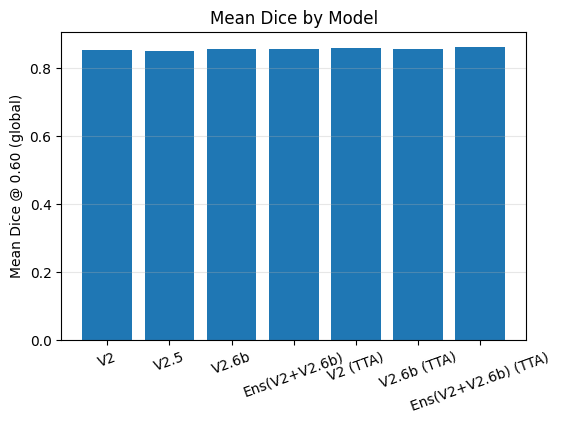

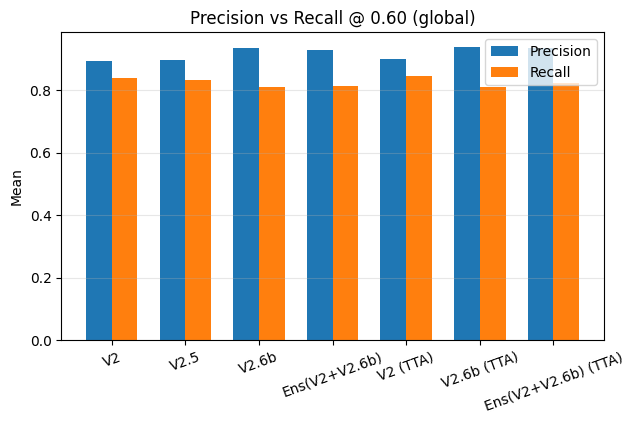

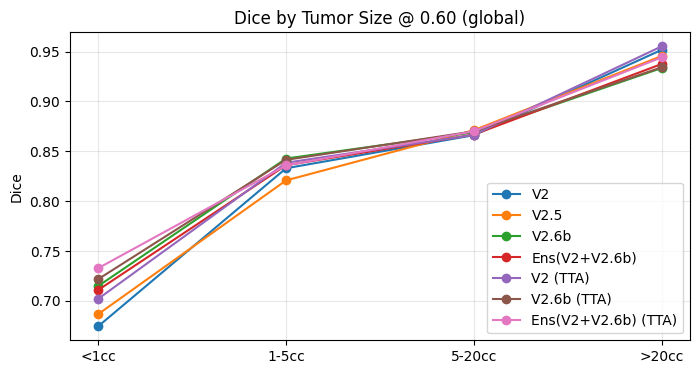

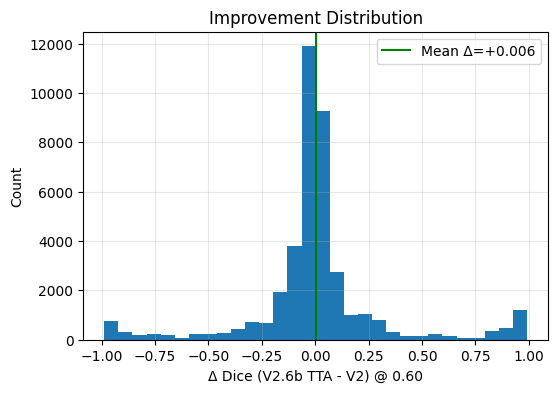

Dashboards saved to /content/drive/MyDrive/BraTS_MEN_eval_v26b (dash_*.png)
All done ✅


In [19]:
# === Consolidated Post-Training + Head-to-Head (V2, V2.5, V2.6b, V3, Ensemble, +TTA & Size-Aware Thr) ===
import os, json, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.transforms import Compose, AsDiscrete, KeepLargestConnectedComponent, FillHoles
from monai.data import Dataset, DataLoader, list_data_collate

try:
    from monai.metrics import SurfaceDistanceMetric
    _HAS_SURF = True
except Exception:
    _HAS_SURF = False

DEVICE = globals().get("device", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
ROI    = globals().get("ROI", (128,128,128))
assert "val_items" in globals() and "val_transforms" in globals(), "Need val_items / val_transforms."

EVAL_DIR = Path("/content/drive/MyDrive/BraTS_MEN_eval_v26b")
EVAL_DIR.mkdir(parents=True, exist_ok=True)

val_ds_full = Dataset(val_items, transform=val_transforms)
val_loader = DataLoader(val_ds_full, batch_size=1, shuffle=False, num_workers=4,
                        pin_memory=True, persistent_workers=True, collate_fn=list_data_collate)

# --- checkpoints
V2_CKPT    = Path("/content/drive/MyDrive/BraTS_MEN_baseline_v2/unet3d_v2.pt")
V25_CKPT   = Path("/content/drive/MyDrive/BraTS_MEN_v2_5_small_tune/unet3d_v2_5_small_best.pt")
V26B_CKPT  = Path("/content/drive/MyDrive/BraTS_MEN_v2_6b_tversky/unet3d_v2_6b_best.pt")
CANDIDATE_V3 = [
    Path(globals().get("SAVE_DIR", Path("/content/drive/MyDrive"))) / "unet3d_v3_best_dice.pt",
    Path("/content/drive/MyDrive/BraTS_MEN_v3_best_dice.pt"),
    Path("/content/drive/MyDrive/unet3d_v3_best_dice.pt"),
]
V3_CKPT = next((p for p in CANDIDATE_V3 if p.exists()), None)

def make_unet():
    return UNet(spatial_dims=3, in_channels=4, out_channels=1,
                channels=(32,64,128,256,512), strides=(2,2,2,2), num_res_units=2, dropout=0.0)

models = {}
def _add(tag, pth):
    if pth and Path(pth).exists():
        m = make_unet().to(DEVICE)
        m.load_state_dict(torch.load(pth, map_location="cpu"))
        m.eval()
        models[tag] = m

_add("V2", V2_CKPT)
_add("V2.5", V25_CKPT)
_add("V2.6b", V26B_CKPT)
_add("V3", V3_CKPT)

DO_ENSEMBLE = ("V2" in models and "V2.6b" in models)
DO_TTA = True  # <—— enable TTA variants

if not models:
    raise RuntimeError("No checkpoints found.")
print("Loaded models:", list(models.keys()), " | Ensemble:", DO_ENSEMBLE, "| TTA:", DO_TTA)

# ---- metrics helpers
def soft_dice_on_probs(p, g, eps=1e-6):
    inter = (p * g).sum(dim=list(range(2, p.ndim)))
    den   = (p * p).sum(dim=list(range(2, p.ndim))) + (g * g).sum(dim=list(range(2, g.ndim)))
    return (2 * inter + eps) / (den + eps)

def compute_confusion(pred_bin, gt_bin):
    p, g = pred_bin.bool(), gt_bin.bool()
    tp = (p & g).sum().item()
    fp = (p & (~g)).sum().item()
    fn = ((~p) & g).sum().item()
    return float(tp), float(fp), float(fn)

def hard_metrics(tp, fp, fn, eps=1e-8):
    dice = (2*tp)/(2*tp+fp+fn+eps)
    prec = tp/(tp+fp+eps)
    rec  = tp/(tp+fn+eps)
    f1   = (2*prec*rec)/(prec+rec+eps)
    return dice, prec, rec, f1

dice_metric = DiceMetric(include_background=False, reduction="none")
hd95_metric = HausdorffDistanceMetric(include_background=False, reduction="none", percentile=95.0, directed=False)
if _HAS_SURF:
    assd_metric = SurfaceDistanceMetric(include_background=False, reduction="none", symmetric=True)

def compute_geo(y_pred_bin, y_bin, spacing):
    try:
        hd = hd95_metric(y_pred_bin, y_bin, spacing=spacing)
        hd95_val = float(hd.detach().cpu().numpy()[0])
    except Exception:
        hd95_val = float("nan")
    if _HAS_SURF:
        try:
            sd = assd_metric(y_pred_bin, y_bin, spacing=spacing)
            assd_val = float(sd.detach().cpu().numpy()[0])
        except Exception:
            assd_val = float("nan")
    else:
        assd_val = float("nan")
    return hd95_val, assd_val

def case_volume_cc(mask_np, spacing):
    return mask_np.sum() * np.prod(spacing) / 1000.0

def extract_subject_and_spacing(batch, b=0):
    try:
        p = str(batch["image_meta_dict"]["filename_or_obj"][b])
        spacing = nib.load(p).header.get_zooms()[:3]
        return Path(p).stem, spacing
    except Exception:
        return f"case_{b}", (1.0,1.0,1.0)

def postproc(thr):
    return Compose([
        AsDiscrete(threshold=thr),
        KeepLargestConnectedComponent(applied_labels=[1], connectivity=3),
        FillHoles(applied_labels=[1], connectivity=3)
    ])

def infer_probs(net, imgs):
    with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        logits = sliding_window_inference(imgs, ROI, 2, net, overlap=0.25)
    return torch.sigmoid(logits)

# --- TTA: flips across x/y/z; unflip and average
_FLIP_SETS = [(), (2,), (3,), (4,), (2,3), (2,4), (3,4), (2,3,4)]  # channel=1, so dims start at 2: (N,C,D,H,W)
def tta_probs(net, imgs):
    preds = []
    for dims in _FLIP_SETS:
        x = torch.flip(imgs, dims=dims) if dims else imgs
        p = infer_probs(net, x)
        if dims: p = torch.flip(p, dims=dims)
        preds.append(p)
    return torch.stack(preds, 0).mean(0)

# ---- thresholds & bins
THRESHOLDS = [0.5, 0.55, 0.6, 0.65]
SIZE_BINS  = [0, 1.0, 5.0, 20.0, 1000.0]
SIZE_LABELS= ["<1cc", "1-5cc", "5-20cc", ">20cc"]
# size-aware threshold policy (tune if you like)
SIZE_THR = {"<1cc": 0.55, "1-5cc": 0.55, "5-20cc": 0.60, ">20cc": 0.65}

# ---- eval
rows = []
with torch.no_grad():
    for bi, batch in enumerate(val_loader):
        imgs = batch["image"].to(DEVICE)
        gts  = batch["seg"].to(DEVICE).float()
        subj, spacing = extract_subject_and_spacing(batch, 0)
        spacing_t = torch.as_tensor(spacing, dtype=torch.float32).unsqueeze(0)

        gt_bin = (gts > 0.5).to(torch.uint8)
        gt_np = gt_bin[0,0].cpu().numpy()
        vol_gt = case_volume_cc(gt_np, spacing)
        size_bin = pd.cut([vol_gt], bins=SIZE_BINS, labels=SIZE_LABELS, include_lowest=True)[0]
        size_thr = SIZE_THR[str(size_bin)] if str(size_bin) in SIZE_THR else 0.60

        # Base probs per model
        probs_base = {name: infer_probs(m, imgs) for name, m in models.items()}
        if DO_ENSEMBLE:
            probs_base["Ens(V2+V2.6b)"] = 0.5*(probs_base["V2"] + probs_base["V2.6b"])

        # TTA probs per model (optional)
        if DO_TTA:
            probs_tta = {f"{name} (TTA)": tta_probs(models[name] if name in models else None, imgs)
                         for name in list(models.keys())}
            if DO_ENSEMBLE:
                probs_tta["Ens(V2+V2.6b) (TTA)"] = 0.5*(tta_probs(models["V2"], imgs) + tta_probs(models["V2.6b"], imgs))
        else:
            probs_tta = {}

        for name, probs in {**probs_base, **probs_tta}.items():
            if probs is None:  # safety if model missing
                continue
            soft_d = float(soft_dice_on_probs(probs, gts).mean().item())

            # Global threshold sweep
            for thr in THRESHOLDS:
                pred_bin = (postproc(thr)(probs) > 0).to(torch.uint8)
                vol_pred = case_volume_cc(pred_bin[0,0].cpu().numpy(), spacing)
                tp, fp, fn = compute_confusion(pred_bin, gt_bin)
                d, p_, r_, f1 = hard_metrics(tp, fp, fn)
                if gt_bin.sum()==0 and pred_bin.sum()==0:
                    hd, assd = 0.0, 0.0
                else:
                    hd, assd = compute_geo(pred_bin.float(), gt_bin.float(), spacing_t)
                rows.append({
                    "subject": subj, "model": name, "thr": thr, "thr_mode": "global",
                    "vol_gt_cc": vol_gt, "size_bin": str(size_bin), "soft_dice": soft_d,
                    "dice": d, "prec": p_, "rec": r_, "f1": f1,
                    "hd95_mm": hd, "assd_mm": assd,
                    "vol_pred_cc": vol_pred, "has_tumor": bool(gt_np.max())
                })

            # Size-aware threshold (single point)
            thr = float(size_thr)
            pred_bin = (postproc(thr)(probs) > 0).to(torch.uint8)
            vol_pred = case_volume_cc(pred_bin[0,0].cpu().numpy(), spacing)
            tp, fp, fn = compute_confusion(pred_bin, gt_bin)
            d, p_, r_, f1 = hard_metrics(tp, fp, fn)
            if gt_bin.sum()==0 and pred_bin.sum()==0:
                hd, assd = 0.0, 0.0
            else:
                hd, assd = compute_geo(pred_bin.float(), gt_bin.float(), spacing_t)
            rows.append({
                "subject": subj, "model": name, "thr": thr, "thr_mode": "size_aware",
                "vol_gt_cc": vol_gt, "size_bin": str(size_bin), "soft_dice": soft_d,
                "dice": d, "prec": p_, "rec": r_, "f1": f1,
                "hd95_mm": hd, "assd_mm": assd,
                "vol_pred_cc": vol_pred, "has_tumor": bool(gt_np.max())
            })

        if (bi+1) % 20 == 0:
            print(f"Processed {bi+1}/{len(val_loader)}")

df = pd.DataFrame(rows)
out_csv = EVAL_DIR / "v2_v25_v26b_v3_percase.csv"
df.to_csv(out_csv, index=False)
print("Saved per-case metrics:", out_csv)

# ---- analysis + plots
best_thr = 0.60
df["size_bin"] = pd.Categorical(df["size_bin"], categories=SIZE_LABELS, ordered=True)

def view(df_, title_tag):
    summary = (df_[(df_["thr_mode"]=="global") & (df_["thr"]==best_thr)]
               .groupby("model")
               .agg(dice_mean=("dice","mean"), dice_std=("dice","std"),
                    prec_mean=("prec","mean"), rec_mean=("rec","mean"), f1_mean=("f1","mean"),
                    hd95_mean=("hd95_mm", lambda s: np.nanmean(np.where(np.isfinite(s), s, np.nan))),
                    assd_mean=("assd_mm", lambda s: np.nanmean(np.where(np.isfinite(s), s, np.nan)))))
    return summary.round(4)

summary = view(df, "global@0.60")
print("\n=== Mean metrics (global thr=0.60) ===\n", summary)

def pair_delta(a,b,metric="dice", mode="global"):
    da = df[(df["model"]==a) & (df["thr_mode"]==mode) & (df["thr"]==best_thr)][["subject",metric]]
    db = df[(df["model"]==b) & (df["thr_mode"]==mode) & (df["thr"]==best_thr)][["subject",metric]]
    m = da.merge(db,on="subject",suffixes=("_a","_b"))
    m["delta"] = m[f"{metric}_b"] - m[f"{metric}_a"]
    return m

# Head-to-head (global@0.60)
head2 = {}
candidates = [m for m in ["V2","V2.5","V2.6b","V3","Ens(V2+V2.6b)","V2 (TTA)","V2.6b (TTA)","Ens(V2+V2.6b) (TTA)"] if m in summary.index]
for i in range(len(candidates)):
    for j in range(i+1, len(candidates)):
        a, b = candidates[i], candidates[j]
        comp = pair_delta(a,b, mode="global")
        if len(comp) > 0:
            head2[f"{a}_vs_{b}"] = {
                "n": int(len(comp)),
                "mean_delta": float(comp["delta"].mean()),
                "pct_improved": float(100*(comp["delta"]>0).mean()),
                "wilcoxon_p": float(wilcoxon(comp["dice_a"], comp["dice_b"]).pvalue) if len(comp)>5 else None
            }

# Size-stratified (global @0.60)
size_perf = (
    df[(df["thr_mode"]=="global") & (df["thr"]==best_thr)]
    .groupby(["model","size_bin"])
    .agg(dice_mean=("dice","mean"), prec_mean=("prec","mean"), rec_mean=("rec","mean"))
    .round(4)
    .reset_index()
)

# Save summary JSON
summary_json = {
    "mean_metrics_global@0.60": summary.to_dict(),
    "head_to_head_global@0.60": head2,
    "size_perf_global@0.60": size_perf.to_dict(orient="records"),
}
out_json = EVAL_DIR / "v2_v25_v26b_v3_summary.json"
with open(out_json, "w") as f:
    json.dump(summary_json, f, indent=2)
print("Saved summary JSON:", out_json)

# Plots (global@0.60)
order = [m for m in ["V2","V2.5","V2.6b","V3","Ens(V2+V2.6b)","V2 (TTA)","V2.6b (TTA)","Ens(V2+V2.6b) (TTA)"] if m in summary.index]

plt.figure(figsize=(6,4))
plt.bar(order, summary.loc[order,"dice_mean"]); plt.ylabel("Mean Dice @ 0.60 (global)")
plt.title("Mean Dice by Model"); plt.grid(True, axis="y", alpha=0.3)
plt.xticks(rotation=20)
plt.savefig(EVAL_DIR / "dash_mean_dice.png", dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(7,4))
x = np.arange(len(order)); w = 0.35
plt.bar(x-w/2, summary.loc[order,"prec_mean"], w, label="Precision")
plt.bar(x+w/2, summary.loc[order,"rec_mean"],  w, label="Recall")
plt.xticks(x, order, rotation=20); plt.ylabel("Mean")
plt.title("Precision vs Recall @ 0.60 (global)")
plt.legend(); plt.grid(True, axis="y", alpha=0.3)
plt.savefig(EVAL_DIR / "dash_prec_rec.png", dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(8,4))
sizes = SIZE_LABELS
for m in order:
    vals = [df[(df["model"]==m)&(df["size_bin"]==s)&(df["thr_mode"]=="global")&(df["thr"]==best_thr)]["dice"].mean() for s in sizes]
    plt.plot(sizes, vals, marker="o", label=m)
plt.ylabel("Dice"); plt.title("Dice by Tumor Size @ 0.60 (global)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.savefig(EVAL_DIR / "dash_size_strat.png", dpi=150, bbox_inches="tight"); plt.show()

# Improvement histogram example: V2.6b (TTA) vs V2 (global@0.60)
if "V2" in summary.index and "V2.6b (TTA)" in summary.index:
    v = pair_delta("V2","V2.6b (TTA)", mode="global")
    if len(v):
        plt.figure(figsize=(6,4))
        plt.hist(v["delta"], bins=30)
        plt.axvline(v["delta"].mean(), color="green", label=f"Mean Δ={v['delta'].mean():+.3f}")
        plt.xlabel("Δ Dice (V2.6b TTA - V2) @ 0.60"); plt.ylabel("Count")
        plt.title("Improvement Distribution")
        plt.legend(); plt.grid(True, alpha=0.3)
        plt.savefig(EVAL_DIR / "dash_improvement_hist_v26bTTA_vs_v2.png", dpi=150, bbox_inches="tight"); plt.show()

print(f"Dashboards saved to {EVAL_DIR} (dash_*.png)")
print("All done ✅")
